In [8]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# 한글 폰트 설정 (Windows)
plt.rcParams['font.family'] = 'Malgun Gothic'

# 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False


### 기업대출 EDA


📌 DF4 RAW HEAD


,통계표,계정항목,단위,변환,2003/Q1,2003/Q2,2003/Q3,2003/Q4,2004/Q1,2004/Q2,...,2023/Q2,2023/Q3,2023/Q4,2024/Q1,2024/Q2,2024/Q3,2024/Q4,2025/Q1,2025/Q2,2025/Q3
0,"1.2.5.2.1. 산업별대출금(예금은행, 전산업)",산업별대출금,십억원,원자료,"266,338.6","277,690.2","285,246.9","284,503.9","294,659.0","295,670.5",...,"1,303,185.4","1,333,599.7","1,350,510.1","1,376,237.7","1,401,619.3","1,421,247.1","1,422,899.1","1,436,710.4","1,451,007.2","1,471,429.0"
1,"1.2.5.2.1. 산업별대출금(예금은행, 전산업)","농업, 임업 및 어업",십억원,원자료,"18,892.3","19,158.0","18,468.8","17,312.3","17,388.4","17,030.8",...,"31,675.2","32,178.4","32,241.3","32,142.6","33,264.4","33,572.8","33,447.7","33,599.1","34,004.4","34,287.6"
2,"1.2.5.2.1. 산업별대출금(예금은행, 전산업)",광업,십억원,원자료,933.1,955.5,937.0,916.4,848.0,848.4,...,"1,066.2","1,063.1",958.6,"1,062.5","1,005.9",933.1,"1,497.8","1,561.4","1,327.6","1,182.7"
3,"1.2.5.2.1. 산업별대출금(예금은행, 전산업)",제조업,십억원,원자료,"104,001.2","106,464.5","108,451.4","105,590.7","109,201.3","110,032.9",...,"408,597.9","418,966.6","420,377.8","431,952.9","438,730.7","446,969.3","447,073.5","453,649.5","459,436.4","463,356.5"
4,"1.2.5.2.1. 산업별대출금(예금은행, 전산업)",식료품 및 음료,십억원,원자료,"7,757.0","7,792.4","7,950.3","7,628.6","7,803.1","7,512.8",...,"32,402.5","32,906.1","33,740.2","34,196.2","34,210.0","34,834.5","35,601.0","35,876.5","36,348.0","36,586.3"



📌 DATE 변환 확인
NaT 개수: 0 / 91

📌 결측치 처리: 선형보간 → 잔여 NaN 행 drop
제거된 행 수: 0

📌 DF4 HEAD (산업별대출금만)


계정항목,date,산업별대출금
0,2004-01-01,294659.0
1,2004-04-01,295670.5
2,2004-07-01,296491.1
3,2004-10-01,289328.8
4,2005-01-01,292520.1
5,2005-04-01,296151.4
6,2005-07-01,301395.0
7,2005-10-01,308408.9
8,2006-01-01,318130.8
9,2006-04-01,329970.6



📌 DF4 SHAPE
(87, 2)

📌 DF4 DTYPES


,dtype
계정항목,
date,datetime64[ns]
산업별대출금,float64



📌 MISSING VALUES


,missing_count
계정항목,
date,0
산업별대출금,0



📌 DESCRIBE


count    8.700000e+01
mean     7.754029e+05
std      3.390560e+05
min      2.893288e+05
25%      5.454436e+05
50%      7.304665e+05
75%      9.882792e+05
max      1.471429e+06
Name: 산업별대출금, dtype: float64


📌 BOXPLOT (산업별대출금)
Mean: 775402.889
Q1  : 545443.650
Q3  : 988279.200


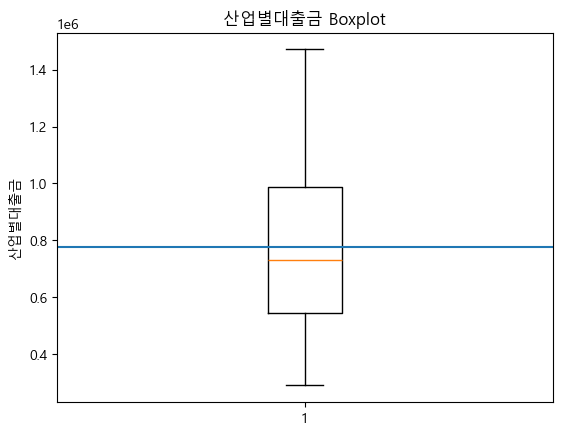

In [ ]:
def section(title):
    print("\n" + "="*60)
    print(f"📌 {title}")
    print("="*60)

# ============================================================
# DF4: 기업대출_산업별.csv
# ✅ 분기별 데이터
# ✅ 행렬 변환(전치)
# ✅ 날짜: datetime (yyyy-mm-dd)  ※ 분기 시작일로 저장
# ✅ 2004Q1 이후만 사용
# ✅ 결측치 처리: 선형보간 → 잔여 NaN 행 drop
# ✅ "산업별대출금" 컬럼만 남김 (총합계)
# ✅ 박스플롯도 해당 컬럼만
# (YoY/Z-score 계산 블록은 주석 처리)
# ============================================================

# 1) 로딩
df4_raw = pd.read_csv("data/기업대출_산업별.csv")
df4 = df4_raw.copy()

section("DF4 RAW HEAD")
display(df4.head())

# 2) 메타 컬럼 삭제
meta_cols = [c for c in df4.columns if any(k in str(c) for k in ["통계표", "단위", "변환"])]
df4 = df4.drop(columns=meta_cols, errors="ignore")

# 3) 첫 컬럼(계정항목)을 index로
item_col = df4.columns[0]
df4 = df4.set_index(item_col)

# 4) 행렬 변환(전치)
df4_t = df4.T.reset_index().rename(columns={"index": "date_raw"})

# 5) 분기 date 생성: 'YYYY/Qn' -> 'YYYYQn' -> Period[Q] -> datetime(분기 시작일)
s = df4_t["date_raw"].astype(str).str.strip()
s = s.str.replace(" ", "", regex=False).str.replace("/", "", regex=False)  # 2003/Q1 -> 2003Q1

q_period = pd.PeriodIndex(s, freq="Q")
df4_t["date"] = q_period.to_timestamp(how="start")  # 예: 2004Q1 -> 2004-01-01

section("DATE 변환 확인")
print("NaT 개수:", df4_t["date"].isna().sum(), "/", len(df4_t))

# 6) 2004Q1 이후 필터
df4_t = df4_t[df4_t["date"] >= pd.Timestamp("2004-01-01")]

# 7) numeric 변환
value_cols = [c for c in df4_t.columns if c not in ["date_raw", "date"]]
for col in value_cols:
    df4_t[col] = (
        df4_t[col].astype(str)
        .str.replace(",", "", regex=False)
        .str.replace(" ", "", regex=False)
        .replace({"": np.nan, "-": np.nan, "nan": np.nan, "None": np.nan})
    )
    df4_t[col] = pd.to_numeric(df4_t[col], errors="coerce")

# 8) 최종 df4 정리 (date 첫 컬럼)
df4 = (
    df4_t.drop(columns=["date_raw"])
    .sort_values("date")
    .reset_index(drop=True)
)
df4 = df4[["date"] + [c for c in df4.columns if c != "date"]]

# 9) 결측치 처리: 선형보간 → 잔여 NaN 행 drop
section("결측치 처리: 선형보간 → 잔여 NaN 행 drop")

num_cols = df4.select_dtypes(include=np.number).columns.tolist()
df4[num_cols] = df4[num_cols].interpolate(method="linear", limit_direction="both")

before_rows = len(df4)
df4 = df4.dropna(subset=num_cols).reset_index(drop=True)
print("제거된 행 수:", before_rows - len(df4))

# ============================================================
# 10) ✅ "산업별대출금" 컬럼만 남기기 (총합계)
# ============================================================
if "산업별대출금" not in df4.columns:
    raise ValueError("⚠️ '산업별대출금' 컬럼이 존재하지 않습니다. 컬럼명을 확인하세요.")

df4 = df4[["date", "산업별대출금"]]


# ============================================================
# 12) EDA
# ============================================================
section("DF4 HEAD (산업별대출금만)")
display(df4.head(10))

section("DF4 SHAPE")
print(df4.shape)

section("DF4 DTYPES")
display(pd.DataFrame(df4.dtypes, columns=["dtype"]))

section("MISSING VALUES")
display(pd.DataFrame(df4.isnull().sum(), columns=["missing_count"]))

section("DESCRIBE")
display(df4["산업별대출금"].describe())

# ============================================================
# 13) 박스플롯 (산업별대출금만)
# ============================================================
section("BOXPLOT (산업별대출금)")

mean_val = df4["산업별대출금"].mean()
Q1 = df4["산업별대출금"].quantile(0.25)
Q3 = df4["산업별대출금"].quantile(0.75)

print(f"Mean: {mean_val:.3f}")
print(f"Q1  : {Q1:.3f}")
print(f"Q3  : {Q3:.3f}")

plt.figure()
plt.boxplot(df4["산업별대출금"].dropna())
plt.axhline(mean_val)
plt.title("산업별대출금 Boxplot")
plt.ylabel("산업별대출금")
plt.show()


In [10]:
# ✅ CSV 저장 (Period는 문자열로 저장)
df4_to_save = df4.copy()
df4_to_save["date"] = df4_to_save["date"].astype(str)
df4_to_save.to_csv("data/전처리_기업대출.csv", index=False, encoding="utf-8-sig")